In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for file in os.listdir('.\\potholes'):
    print(file)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1.jpg
1.xml
10.jpg
10.xml
100.jpg
100.xml
101.jpg
101.xml
102.jpg
102.xml
103.jpg
103.xml
104.jpg
104.xml
105.jpg
105.xml
106.jpg
106.xml
107.jpg
107.xml
108.jpg
108.xml
109.jpg
109.xml
11.jpg
11.xml
110.jpg
110.xml
111.jpg
111.xml
112.jpg
112.xml
113.jpg
113.xml
114.jpg
114.xml
115.jpg
115.xml
116.jpg
116.xml
117.jpg
117.xml
118.jpg
118.xml
119.jpg
119.xml
12.jpg
12.xml
120.jpg
120.xml
121.jpg
121.xml
122.jpg
122.xml
123.jpg
123.xml
124.jpg
124.xml
125.jpg
125.xml
126.jpg
126.xml
127.jpg
127.xml
128.jpg
128.xml
129.jpg
129.xml
13.jpg
13.xml
130.jpg
130.xml
131.jpg
131.xml
132.jpg
132.xml
133.jpg
133.xml
134.jpg
134.xml
135.jpg
135.xml
136.jpg
136.xml
137.jpg
137.xml
138.jpg
138.xml
139.jpg
139.xml
14.jpg
14.xml
140.jpg
140.xml
141.jpg
141.xml
142.jpg
142.xml
143.jpg
143.xml
144.jpg
144.xml
145.jpg
145.xml
146.jpg
146.xml
147.jpg
147.xml
148.jpg
148.xml
149.jpg
149.xml
15.jpg
15.xml
150.jpg
150.xml
151.jpg
151.xml
152.jpg
152.xml
153.jpg
153.xml
154.jpg
154.xml
155.jpg
155.xml
156.jpg


In [2]:
from xml.etree import ElementTree as et
import glob
boxes = []
labels = []


for xml in glob.glob('.\\potholes\\*.xml'):
    tree = et.parse(xml)
    root = tree.getroot()
    for member in root.findall('object'):
        # map the current object name to `classes` list to get...
        # ... the label index and append to `labels` list
#         print(member.find('name').text)
        labels.append(member.find('name').text)
        # xmin = left corner x-coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        # xmax = right corner x-coordinates
        xmax = int(member.find('bndbox').find('xmax').text)
        # ymin = left corner y-coordinates
        ymin = int(member.find('bndbox').find('ymin').text)
        # ymax = right corner y-coordinates
        ymax = int(member.find('bndbox').find('ymax').text)
        #if(ymax<=ymin):
        print(xmin,xmax,ymin,ymax)

377 737 385 505
396 703 302 380
73 194 167 215
154 278 119 164
466 613 62 139
250 365 44 109
927 1036 353 436
315 696 198 467
131 289 294 366
173 559 320 465
477 800 162 339
586 800 362 533
216 437 251 351
1 160 372 447
45 164 221 283
464 584 176 253
1 264 85 254
300 479 69 171
492 628 124 205
395 563 286 419
71 186 150 220
1 85 109 181
89 153 104 141
147 192 45 131
1 137 38 60
668 1495 648 837
273 656 556 739
118 542 284 518
397 1134 58 1639
1841 2453 1133 1671
1291 2234 264 1096
466 2972 1046 1621
859 2284 777 1114
653 1609 589 758
171 493 186 343
170 605 304 439
200 468 128 203
432 684 212 266
215 408 243 295
496 1130 131 463
96 467 92 246
433 818 273 585
865 1272 234 810
1 343 515 812
1 201 14 155
284 581 346 418
1 283 360 459
164 524 260 359
72 278 117 239
314 522 124 248
183 348 164 235
3 96 92 196
106 236 66 194
1 330 498 727
476 1184 159 413
48 199 46 110
24 97 121 171
572 745 345 426
189 659 443 553
1 534 194 401
82 257 27 132
22 244 93 199
187 414 170 286
20 327 187 330
359 4

In [3]:
import cv2
cv2.imread('.\\potholes\\1.jpg').shape

(768, 1024, 3)

In [4]:
print(np.unique(labels))

['crack' 'damage' 'pothole' 'pothole_water' 'pothole_water_m']


In [5]:
# configs
import torch

BATCH_SIZE = 8 # increase / decrease according to GPU memeory
RESIZE_TO = 768 # resize the image for training and transforms
NUM_EPOCHS = 50 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '.\\potholes'
# validation images and XML files directory
# VALID_DIR = '../input/underwater-trash-detection/val'

# classes: 0 index is reserved for background
CLASSES = [
    'background','crack' ,'damage' ,'pothole' ,'pothole_water' ,'pothole_water_m'
]
NUM_CLASSES = 6

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots

OUT_DIR = '.\\outputs'
SAVE_PLOTS_EPOCH = 1 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 1 # save model after these many epochs

In [6]:
#utils
import albumentations as A
import cv2
import numpy as np

from albumentations.pytorch import ToTensorV2

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            plt.imshow(sample)
            plt.title('Transformed Image')
            plt.show()

In [7]:
import numpy as np
from mean_average_precision import MetricBuilder
def get_batch_mAP(outputs,targets):
    # print list of available metrics
#     print(MetricBuilder.get_metrics_list())
    # create metric_fn
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=NUM_CLASSES)
    # add some samples to evaluation
    
    for b in range(len(outputs)):
        preds = []
        for i in range(len(outputs[b]['boxes'])):
            bboxes = outputs[b]['boxes'][i].tolist()
            label = outputs[b]['labels'][i].tolist()
            score = outputs[b]['scores'][i].tolist()
            pred = bboxes + [label,score]
            preds.append(pred)
        preds = np.array(preds)
        
        gts = []
        for i in range(len(targets[b]['boxes'])):
            bboxes = targets[b]['boxes'][i].tolist()
            label = targets[b]['labels'][i].tolist()
            crowd = targets[b]['iscrowd'][i].tolist()
            gt = bboxes + [label,0,crowd]
            gts.append(gt)
        gts = np.array(gts)
        
        metric_fn.add(preds, gts)
    # compute PASCAL VOC metric
#     print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")
    voc_pascal_map = metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    # compute PASCAL VOC metric at the all points
#     print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")
    voc_pascal_map_allpts = metric_fn.value(iou_thresholds=0.5)['mAP']

    # compute metric COCO metric
#     print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")
    coco_map = metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']
    return voc_pascal_map,voc_pascal_map_allpts,coco_map    
        


In [8]:
import torch
import cv2
import numpy as np
import os
import glob as glob

from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models

# the dataset class
class PotholeDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}\\*.jpg")
        self.all_images = [image_path.split('\\')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_path.replace('jpg','xml')
        annot_file_path = annot_filename
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [9]:
# prepare the final datasets and data loaders
train_data = PotholeDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
# valid_dataset = TrashDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
valid_size=0.2
train_size=1-valid_size
num_train=len(train_data)
split=int(np.floor(valid_size*num_train))
train_dataset, val_dataset = random_split(train_data, (num_train-split,split))
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}\n")

Number of training samples: 400
Number of validation samples: 100



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 500
{'boxes': tensor([[282.7500, 385.0000, 552.7500, 505.0000],
        [297.0000, 302.0000, 527.2500, 380.0000]]), 'labels': tensor([3, 3]), 'area': tensor([32400.0000, 17959.5000]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([0])}


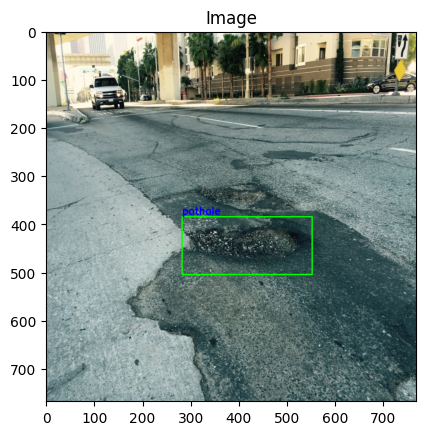

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[ 84.9455, 345.7035, 225.7455, 445.0674],
        [179.2000, 246.3396, 323.4909, 339.4933],
        [542.2545, 128.3450, 713.3091, 287.7412],
        [290.9091,  91.0836, 424.7273, 225.6388]]), 'labels': tensor([4, 4, 4, 4]), 'area': tensor([13990.4346, 13441.2217, 27265.4512, 18005.9375]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([1])}


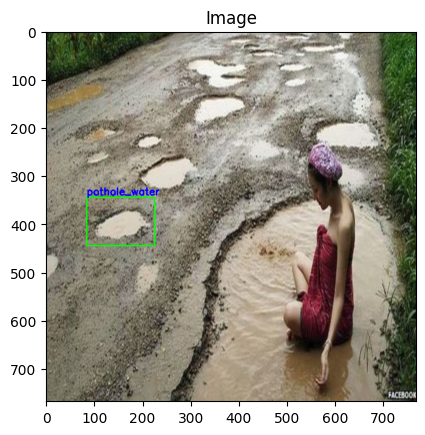

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[548.0646, 314.1414, 612.5081, 388.0046],
        [186.2356, 176.2039, 411.4919, 415.5921]]), 'labels': tensor([4, 2]), 'area': tensor([ 4760.0024, 53923.7109]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([2])}


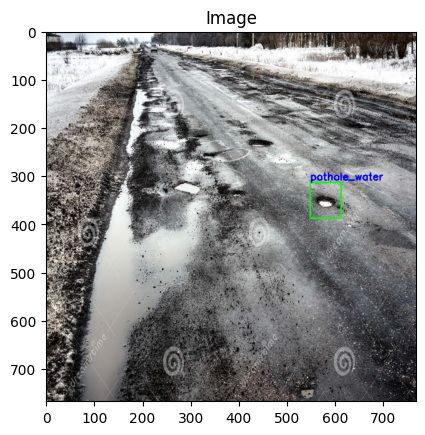

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[167.6800, 564.4800, 369.9200, 702.7200]]), 'labels': tensor([3]), 'area': tensor([27957.6582]), 'iscrowd': tensor([0]), 'image_id': tensor([3])}


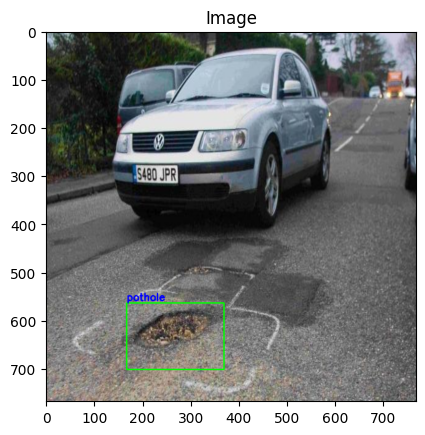

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[166.0800, 461.0882, 536.6400, 670.0187],
        [457.9200, 233.4259, 768.0000, 488.4653],
        [562.5600, 521.6060, 768.0000, 768.0000]]), 'labels': tensor([4, 4, 4]), 'area': tensor([77421.3125, 79082.6172, 50619.1797]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([4])}


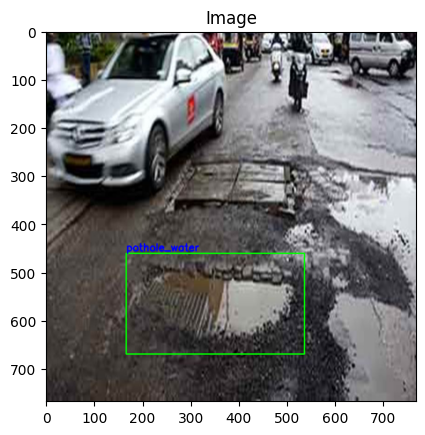

In [10]:
dataset = PotholeDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES)
print(f"Number of training images: {len(dataset)}")
#print(dataset.image_paths)

# function to visualize a single sample
def visualize_sample(image, target):
    box = target['boxes'][0]
    label = CLASSES[target['labels'][0]]
    cv2.rectangle(
        image, 
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0), 2
    )
    cv2.putText(
        image, label, (int(box[0]), int(box[1]-5)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
    plt.imshow(image)
    plt.title('Image')
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    print(target)
    visualize_sample(image, target)

In [11]:
# model
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [12]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')
#model.train()
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        desc= ""
        for key,value in loss_dict.items():
            desc+=f"{key}: {value:.4f} "
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=desc+f"Loss: {loss_value:.4f}")
        print(train_itr,end='')
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
#             print(targets)
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [13]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [14]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    from utils import show_tranformed_image
    show_tranformed_image(train_loader)

In [15]:
len(valid_loader)

13

In [16]:
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    print(1)
    val_loss_hist.reset()
    print(2)

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    print(3)
    figure_2, valid_ax = plt.subplots()
    print(4)

    # start timer and carry out training and validation
    start = time.time()
    print('starting training')
    train_loss = train(train_loader, model)
    print('starting validating')
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        print('1st loop')
        torch.save(model.state_dict(), f"{OUT_DIR}\\model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        print('2st loop')
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}\\train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}\\valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        print('3st loop')
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}\\train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}\\valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}\\model{epoch+1}.pth")

    plt.close('all')
    # sleep for 5 seconds after each epoch
    time.sleep(5)


EPOCH 1 of 50
1
2
3
4
starting training
Training


  0%|          | 0/50 [00:00<?, ?it/s]

234567891011121314151617

In [17]:
#inference
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import glob as glob

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=6).to(device)
model.load_state_dict(torch.load(
    '.\\outputs\\model1.pth', map_location=device
))
model.eval()

# directory where all the images are present
DIR_TEST = '.\\testing'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
test_images = [x for x in test_images if 'predicted' not in x]
print(test_images)
print(f"Test instances: {len(test_images)}")

# classes: 0 index is reserved for background
CLASSES = [
    'background','crack' ,'damage' ,'pothole' ,'pothole_water' ,'pothole_water_m'
]

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.5

['.\\testing\\21.jpg', '.\\testing\\test1.jp.jpg', '.\\testing\\test2.jpg']
Test instances: 3


C:\Users\hariv\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


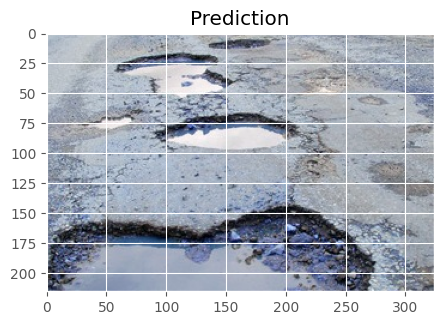

Image 1 done...
--------------------------------------------------
Image 2 done...
--------------------------------------------------
Image 3 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [18]:
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(orig_image, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)
            
            
        plt.figure(figsize=(5,5))
        plt.imshow(orig_image)
        plt.title('Prediction')
        plt.show()
        cv2.imwrite(f".\\predicted_{i+1}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')

In [19]:
from tqdm import tqdm
# initialize tqdm progress bar
prog_bar = tqdm(valid_loader, total=len(valid_loader))

voc_map = []
voc_all_map = []
c_map = []
model.eval()
for i, data in enumerate(prog_bar):
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    with torch.no_grad():
#             print(targets)
        outputs = model(images)
    
#     print('Batch : ',i)
    a,b,c = get_batch_mAP(outputs,targets)
    voc_map.append(a)
    voc_all_map.append(b)
    c_map.append(c)
print(f"VOC PASCAL mAP : {np.mean(voc_map)}")
print(f"VOC PASCAL mAP in all points : {np.mean(voc_all_map)}")
print(f"COCO mAP: {np.mean(c_map)}")

100%|██████████| 13/13 [04:43<00:00, 21.83s/it]

VOC PASCAL mAP : 0.09916358441114426
VOC PASCAL mAP in all points : 0.09449297934770584
COCO mAP: 0.035830412060022354
